# Initialization

### Hyper-parameters (variables)

In [1]:
PRINT_FREQ = 1  # sparsity calculations' print frequency w/ modulus operandi.
KERNEL_SIZE = 9  # Kernel value of the dimensions for convolutional features.
WINDOW_SIZE = 7  # number of frames for each windowed video batch
batch_split = 35  # number of splits for each window video batch
LCA_ITERS = 1000  # number of LCA timesteps per forward pass
FEATURES = 50  # number of dictionary features to learn
LAMBDA = 2  # neuron activation threshold
STRIDE = 2  # LCA convolutional stride
EPOCHS = 1  # periods of training
TAU = 200  # LCA time constant

### Dependencies

In [2]:
# system modules
import csv
import glob
import itertools
import math
import os
import pickle
import time

import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# PyTorch module and methods
import torch
import torch.nn.functional as F
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from jupyterplot import ProgressPlot

# numpy, scipy, pandas, matplotlib
from matplotlib.animation import FuncAnimation

# image processing modules
from PIL import Image
from scipy import stats
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid, save_image

# Progress bar module
from tqdm import tqdm

# local module for linked-dictionary LCA
from lcapt.analysis import make_feature_grid
from lcapt.lca import LCAConv1D, LCAConv2D, LCAConv3D
from lcapt.metric import compute_frac_active, compute_l1_sparsity, compute_l2_error
from lcapt.preproc import make_unit_var, make_zero_mean
from lcapt.pvutils import animate_energy

2022-09-20 05:22:55.662917: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-20 05:22:55.857936: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-20 05:22:55.857959: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-20 05:22:55.891677: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-20 05:22:56.794205: W tensorflow/stream_executor/platform/de

# Datasets

### Video

In [3]:
torch.cuda.set_device(3)

movie = BrainObservatoryCache().get_ophys_experiment_data(501940850).get_stimulus_template("natural_movie_three")

torch_wf = torch.empty(size=(len(movie) - WINDOW_SIZE + 1, WINDOW_SIZE, movie.shape[-2], movie.shape[-1]))
i = 0

for ind, im in enumerate(movie):
    if len(movie[i : i + WINDOW_SIZE]) == WINDOW_SIZE:
        torch_wf[ind] = torch.tensor(movie[i : i + WINDOW_SIZE])
        i += 1

print(torch_wf.size())

splitted30_wf = torch.split(torch_wf, 30, 0)
splitted10_wf = torch.split(torch_wf, 10, 0)
print("incomplete batch", splitted10_wf[-1].shape)
print("batches_amount(10r/b): ", len(splitted10_wf))

torch.Size([3594, 7, 304, 608])
incomplete batch torch.Size([4, 7, 304, 608])
batches_amount(10r/b):  360


### Traces

##### Read dataset and simple split

In [4]:
%%time

exps_cells = []
column_exp = []
column_cell = []
complete_column_cell_exp_list = []

# IMPORTANT TO NOT UPLOAD dff.h5 IF REPO DEV
dff_df = pd.read_hdf("../data/V1 Responses/dff.h5")

# slice by column cell and column experiment
for column in dff_df.columns[7:]:
    complete_column_cell_exp_list.append(column)
    column_cell.append(column.split("_")[0])
    column_exp.append(column.split("_")[1])

# unique experiment IDs
new_column_exp = np.unique(column_exp)

print("Average cell count per experiment:")
print(
    len(np.unique(column_cell)) // len(np.unique(column_exp)),
    "=",
    len(np.unique(column_cell)),
    "//",
    len(np.unique(column_exp)),
)

# filter by experiment index
for exp_index in range(15, 22):
    for cell_exp in complete_column_cell_exp_list:
        if str(cell_exp).endswith(new_column_exp[exp_index]):
            exps_cells.append(cell_exp)

# print('total cells:', len(exps_cells))

Average cell count per experiment:
247 = 12380 // 50
CPU times: user 8.95 s, sys: 3.58 s, total: 12.5 s
Wall time: 12.5 s


##### dataframe and tensor split
###### using all repetitions or first repetition only of each cell (time consuming ([2-3 min for first repetitions only])



In [5]:
%%time

dff_exps_movie3_list = []
dff_exps = dff_df[["frame", "repeat", "stimulus", "session_type", *exps_cells]]

for exp_cell in exps_cells:
    if dff_exps[dff_exps["stimulus"] == "natural_movie_three"][exp_cell].values.all() == False:
        dff_exp_cell = dff_exps[["stimulus", exp_cell]].where(dff_exps["stimulus"] == "natural_movie_three").dropna()
        dff_exp_rep = torch.tensor(dff_exp_cell[exp_cell].values)
        dff_exp_movie_tensors = torch.split(dff_exp_rep, 3600, 0)

        for ind, dff_exp_sample in enumerate(dff_exp_movie_tensors):
            # ind == 0 is only using the first repetition per cell
            if ind == 0:
                dff_exps_movie3_list.append(dff_exp_sample)
            # dff_exps_movie3_list.append(dff_exp_sample)

dff_exps_movie3 = torch.stack(dff_exps_movie3_list)
print(len(torch.stack(dff_exps_movie3_list)), dff_exps_movie3.shape, "\n")

torch_wt = torch.empty(
    size=(len(dff_exps_movie3_list), dff_exps_movie3.shape[1] - WINDOW_SIZE + 1, WINDOW_SIZE)
).cuda()

for trace_ind, trace in enumerate(dff_exps_movie3):
    torch_wt[trace_ind] = torch.from_numpy(
        np.lib.stride_tricks.sliding_window_view(dff_exps_movie3[trace_ind].cpu().numpy(), window_shape=WINDOW_SIZE)
    )

splitted30_wt = torch.split(torch.moveaxis(torch_wt, 1, 0), 30, 0)
splitted10_wt = torch.split(torch.moveaxis(torch_wt, 1, 0), 10, 0)
print(torch_wt.shape, torch_wt[trace_ind].shape, splitted10_wt[-1].shape, len(splitted10_wt))

511 torch.Size([511, 3600]) 

torch.Size([511, 3594, 7]) torch.Size([3594, 7]) torch.Size([4, 511, 7]) 360
CPU times: user 27min 59s, sys: 2min 3s, total: 30min 3s
Wall time: 2min 39s


<timed exec>:24: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/torch/csrc/utils/tensor_numpy.cpp:178.)


In [6]:
print(torch_wt[trace_ind].shape, splitted30_wt[-1].shape, len(splitted30_wt))

torch.Size([3594, 7]) torch.Size([24, 511, 7]) 120


# LCA Training 

### Model Initialization

In [7]:
# Enable interactive plot
%matplotlib widget
lca = LCAConv3D(
    140,
    1,
    "linked_testing",
    9,
    9,
    7,
    2,
    2,
    1,
    2,  # lca_thresh = lambda
    no_time_pad=True,
    lca_iters=1000,
    return_all=False,
)

torch.cuda.set_device(3)
cuda0 = torch.device("cuda:0")
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(torch.cuda.utilization(torch.device("cuda:3" if torch.cuda.is_available() else "cpu")))

with torch.no_grad():
    ckpt = torch.load("../models/testLinkDict.pth")
    lca.assign_weight_values(ckpt.module.weights)
    # print('starting...')

    # windowed_frames_batch = splitted10_wf[0]
    # windowed_traces_batch = splitted10_wt[0]
    # windowed_frames_batch = torch.unsqueeze(windowed_frames_batch.cuda(), 1)
    # windowed_frames_batch = make_unit_var(make_zero_mean(windowed_frames_batch))
    # windowed_traces_batch = make_unit_var(make_zero_mean(windowed_traces_batch[:, :100]))

    # print('booting...')
    # code = lca((windowed_frames_batch.cuda(), windowed_traces_batch.cuda()))

    # print('finished...')
    # recon, trace_recon = lca.compute_recon(code, lca.weights, True)
    # print(trace_recon.shape)


lca.n_cells = 100  # change to how many cells used
lca = torch.nn.DataParallel(lca, device_ids=[3]).cuda()
print(torch.cuda.current_device())

# pp = ProgressPlot(plot_names=["l1_sparsity", "l2_trace_recon_error"], x_lim=[0, len(splitted10_wt)], y_lim=[[0, 1000000],[0, 1000]])

0
3


### Input Feed and Saving

In [8]:
%matplotlib inline
# plot feature responses over time (max pool or ave. pool)
# plot mice neuron responses (per neuron) for the same stimuli
# trying to match the feature over time with the neuron responses
# average out the repetitions of each cells' responses to compare with feature responses over time

acts_list = []
recon_list = []
recon_error_list = []
trace_recon_list = []
trace_recon_error_list = []

trace_act_usage = torch.zeros(
    (
        len(splitted30_wt[: len(splitted30_wt) // 12]) * 30,
        lca.module.trace_weights.shape[0],
        torch_wf.shape[-1] // 4,
        torch_wf.shape[-2],
    ),
    device="cpu",
)  # print('trace_act_usage shape: ', trace_act_usage.shape)
pp = ProgressPlot(
    plot_names=["l1_sparsity", "l2_trace_recon_error"],
    x_lim=[0, len(splitted30_wf) // 12],
    y_lim=[[0, 5000000], [0, 500]],
)

for ind, (windowed_frames_batch, windowed_traces_batch) in enumerate(
    zip(splitted30_wf[: len(splitted30_wf) // 12], splitted30_wt[: len(splitted30_wt) // 12])
):

    windowed_frames_batch = windowed_frames_batch.cuda()
    windowed_frames_batch = torch.unsqueeze(windowed_frames_batch, 1)
    windowed_frames_batch = make_unit_var(make_zero_mean(windowed_frames_batch))

    windowed_traces_batch = make_unit_var(make_zero_mean(windowed_traces_batch[:, :100].cuda()))
    activations = lca((windowed_frames_batch, windowed_traces_batch), ind).cuda(3)
    print(activations[0].shape, len(activations))
    acts_list.append(activations)

    recon, trace_recon = lca.module.compute_recon(activations, lca.module.weights, True)

    trace_recon_error = windowed_traces_batch - trace_recon
    recon_error = windowed_frames_batch - recon

    lca.module.update_weights(activations, windowed_frames_batch - recon, windowed_traces_batch - trace_recon, ind)
    for i, activation_batch in enumerate(activations):
        for j, feature_acts in enumerate(activation_batch):
            trace_act_usage[30 * ind + i, j] = feature_acts.squeeze(0).cpu()
            if i == len(activations) - 1 and j == len(activation_batch) - 1:
                print(f"at batch ind {ind}, activations i {i + 1}, activation_batch j {j + 1}")
                print(
                    f"shape of activations per feature {feature_acts.shape}, nonzero activations {feature_acts.count_nonzero()}"
                )
    # if ind % PRINT_FREQ == 0:
    l1_sparsity = compute_l1_sparsity(activations, lca.module.lambda_).item()
    l2_recon_error = compute_l2_error(windowed_frames_batch, recon).item()
    l2_trace_recon_error = compute_l2_error(windowed_traces_batch, trace_recon).item()
    total_energy = l2_recon_error + l1_sparsity + l2_trace_recon_error
    pp.update([[l1_sparsity], [l2_trace_recon_error]])

    # print(f'L2 Trace Recon Error: {round(l2_trace_recon_error, 2)}; ',
    #         f'L2 Recon Error: {round(l2_recon_error, 2)}; ',
    #         f'L1 Sparsity: {round(l1_sparsity, 2)};  ',
    #         f'Total Energy: {round(total_energy, 2)};')
    # print(f'acts_all: {activations.shape}, nonzero_counter on activity: {torch.count_nonzero(activations)} out of {torch.numel(activations)}')
    # group the neurons by feature (looking at video)
    recon_list.append(recon)
    recon_error_list.append(recon_error)
    trace_recon_list.append(trace_recon)
    trace_recon_error_list.append(trace_recon_error)
    torch.save(trace_act_usage[ind * 30 : (ind * 30) + 30], f"../data/trace_act_usage/lca_chckpnt_{ind}.pt")

    # if ind > 0 and ind < 2:
    #     print("plotting...")
    # fig, axs = plt.subplots(1, 1, figsize=(16, 9))
    # # fig0, axs0 = plt.subplots(1, 1, figsize=(16, 9))
    # axs.scatter(range(140), trace_feat_usage[ind].cpu().numpy())
    # axs0.scatter(range(140), trace_act_usage[ind].cpu().numpy())
    # plt.show()
    #     fig1, axs1 = plt.subplots(1, 7, figsize=(16, 9))
    #     fig2, axs2 = plt.subplots(1, 7, figsize=(16, 9))
    #     fig3, axs3 = plt.subplots(1, 7, figsize=(16, 9))
    #     for a_ind, (a1, a2, a3) in enumerate(zip(axs1, axs2, axs3)):
    #         recon_samples = recon[0].squeeze().squeeze().cpu().numpy()
    #         recon_error_samples = recon_error[0].squeeze().squeeze().cpu().numpy()
    #         trace_recon_samples = trace_recon[0].squeeze().squeeze().cpu().numpy()

    #         recon_sample = recon_samples[a_ind]
    #         recon_error_sample = recon_error_samples[a_ind]
    #         inputs_sample = recon_error_sample + recon_sample

    #         recon_sample = (recon_sample - recon_sample.min()) / (recon_sample.max() - recon_sample.min())
    #         inputs_sample = (inputs_sample - inputs_sample.min()) / (inputs_sample.max() - inputs_sample.min())
    #         recon_error_sample = (recon_error_sample - recon_error_sample.min()) / (
    #             recon_error_sample.max() - recon_error_sample.min()
    #         )

    #         img1 = a1.imshow(inputs_sample, cmap="gray")
    #         img2 = a2.imshow(recon_sample, cmap="gray")
    #         img3 = a3.imshow(recon_error_sample, cmap="gray")

    #         a1.set_title(f"Input frame{a_ind+1}")
    #         a2.set_title(f"Recon frame{a_ind+1}")
    #         a3.set_title(f"Recon Error frame{a_ind+1}")
    #     plt.show()
    #     plt.close()

    # if ind > 87 and ind < 89:
    #     print("plotting...")
    #     fig1, axs1 = plt.subplots(1, 7, figsize=(16, 9))
    #     fig2, axs2 = plt.subplots(1, 7, figsize=(16, 9))
    #     fig3, axs3 = plt.subplots(1, 7, figsize=(16, 9))
    #     for a_ind, (a1, a2, a3) in enumerate(zip(axs1, axs2, axs3)):
    #         recon_samples = recon[0].squeeze().squeeze().cpu().numpy()
    #         recon_error_samples = recon_error[0].squeeze().squeeze().cpu().numpy()
    #         trace_recon_samples = trace_recon[0].squeeze().squeeze().cpu().numpy()

    #         recon_sample = recon_samples[a_ind]
    #         recon_error_sample = recon_error_samples[a_ind]
    #         inputs_sample = recon_error_sample + recon_sample

    #         recon_sample = (recon_sample - recon_sample.min()) / (recon_sample.max() - recon_sample.min())
    #         inputs_sample = (inputs_sample - inputs_sample.min()) / (inputs_sample.max() - inputs_sample.min())

    #         img1 = a1.imshow(inputs_sample, cmap="gray")
    #         img2 = a2.imshow(recon_sample, cmap="gray")
    #         img3 = a3.imshow(recon_error_sample, cmap="gray")

    #         a1.set_title(f"Input frame{a_ind+1}")
    #         a2.set_title(f"Recon frame{a_ind+1}")
    #         a3.set_title(f"Recon Error frame{a_ind+1}")
    #     plt.show()
    #     plt.close()

pp.finalize()
torch.save(lca, f"../models/testLinkDict.pth")

torch.Size([140, 1, 152, 304]) 30
at batch ind 0, activations i 30, activation_batch j 140
shape of activations per feature torch.Size([1, 152, 304]), nonzero activations 7331
torch.Size([140, 1, 152, 304]) 30
at batch ind 1, activations i 30, activation_batch j 140
shape of activations per feature torch.Size([1, 152, 304]), nonzero activations 87
torch.Size([140, 1, 152, 304]) 30
at batch ind 2, activations i 30, activation_batch j 140
shape of activations per feature torch.Size([1, 152, 304]), nonzero activations 212
torch.Size([140, 1, 152, 304]) 30
at batch ind 3, activations i 30, activation_batch j 140
shape of activations per feature torch.Size([1, 152, 304]), nonzero activations 113
torch.Size([140, 1, 152, 304]) 30
at batch ind 4, activations i 30, activation_batch j 140
shape of activations per feature torch.Size([1, 152, 304]), nonzero activations 0
torch.Size([140, 1, 152, 304]) 30
at batch ind 5, activations i 30, activation_batch j 140
shape of activations per feature tor

torch.Size([300, 152, 304]) torch.Size([300, 140, 152, 304])
0 torch.Size([152, 304]) torch.Size([300])


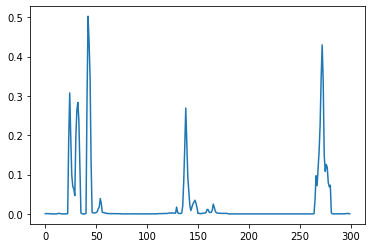

In [29]:
# print(trace_act_usage.max(-3, -2, -1).values)
# max_act_usage = trace_act_usage.max(-3, -2, -1)
# plt.scatter(range(140), max_act_usage.values.cpu().numpy())
print(trace_act_usage[:, feat_ind].shape, trace_act_usage.shape)
print(feat_ind, trace_act_usage[:, feat_ind].mean(0).shape, trace_act_usage[:, feat_ind].mean((-2, -1)).shape)
plt.plot(range(len(trace_act_usage[:, feat_ind].mean((-2, -1)))), trace_act_usage[:, 1].mean((-2, -1)))

# fig, axs = plt.subplots(70, 2, figsize=(20, 30))
# for feat_ind in range(trace_act_usage.shape[1]):
#     max_act_usage = trace_act_usage[:, feat_ind].max((-2, -1))
#     if feat_ind < trace_act_usage.shape[1] // 2:
#         axs[feat_ind, 0].plot(
# 			range(360), max_act_usage.values.cpu().numpy())
#     else:
#         axs[feat_ind - (trace_act_usage.shape[1] // 2), 1].plot(
# 			range(360), max_act_usage.values.cpu().numpy())
# plt.show()

In [86]:
trace_act_usage.mean((-2, -1)).min(0).values.min(0).values
# sum_act_usage = trace_act_usage[:, feat_ind].sum((-2, -1))
# sum_act_usage.shape, feat_ind

tensor(0.)

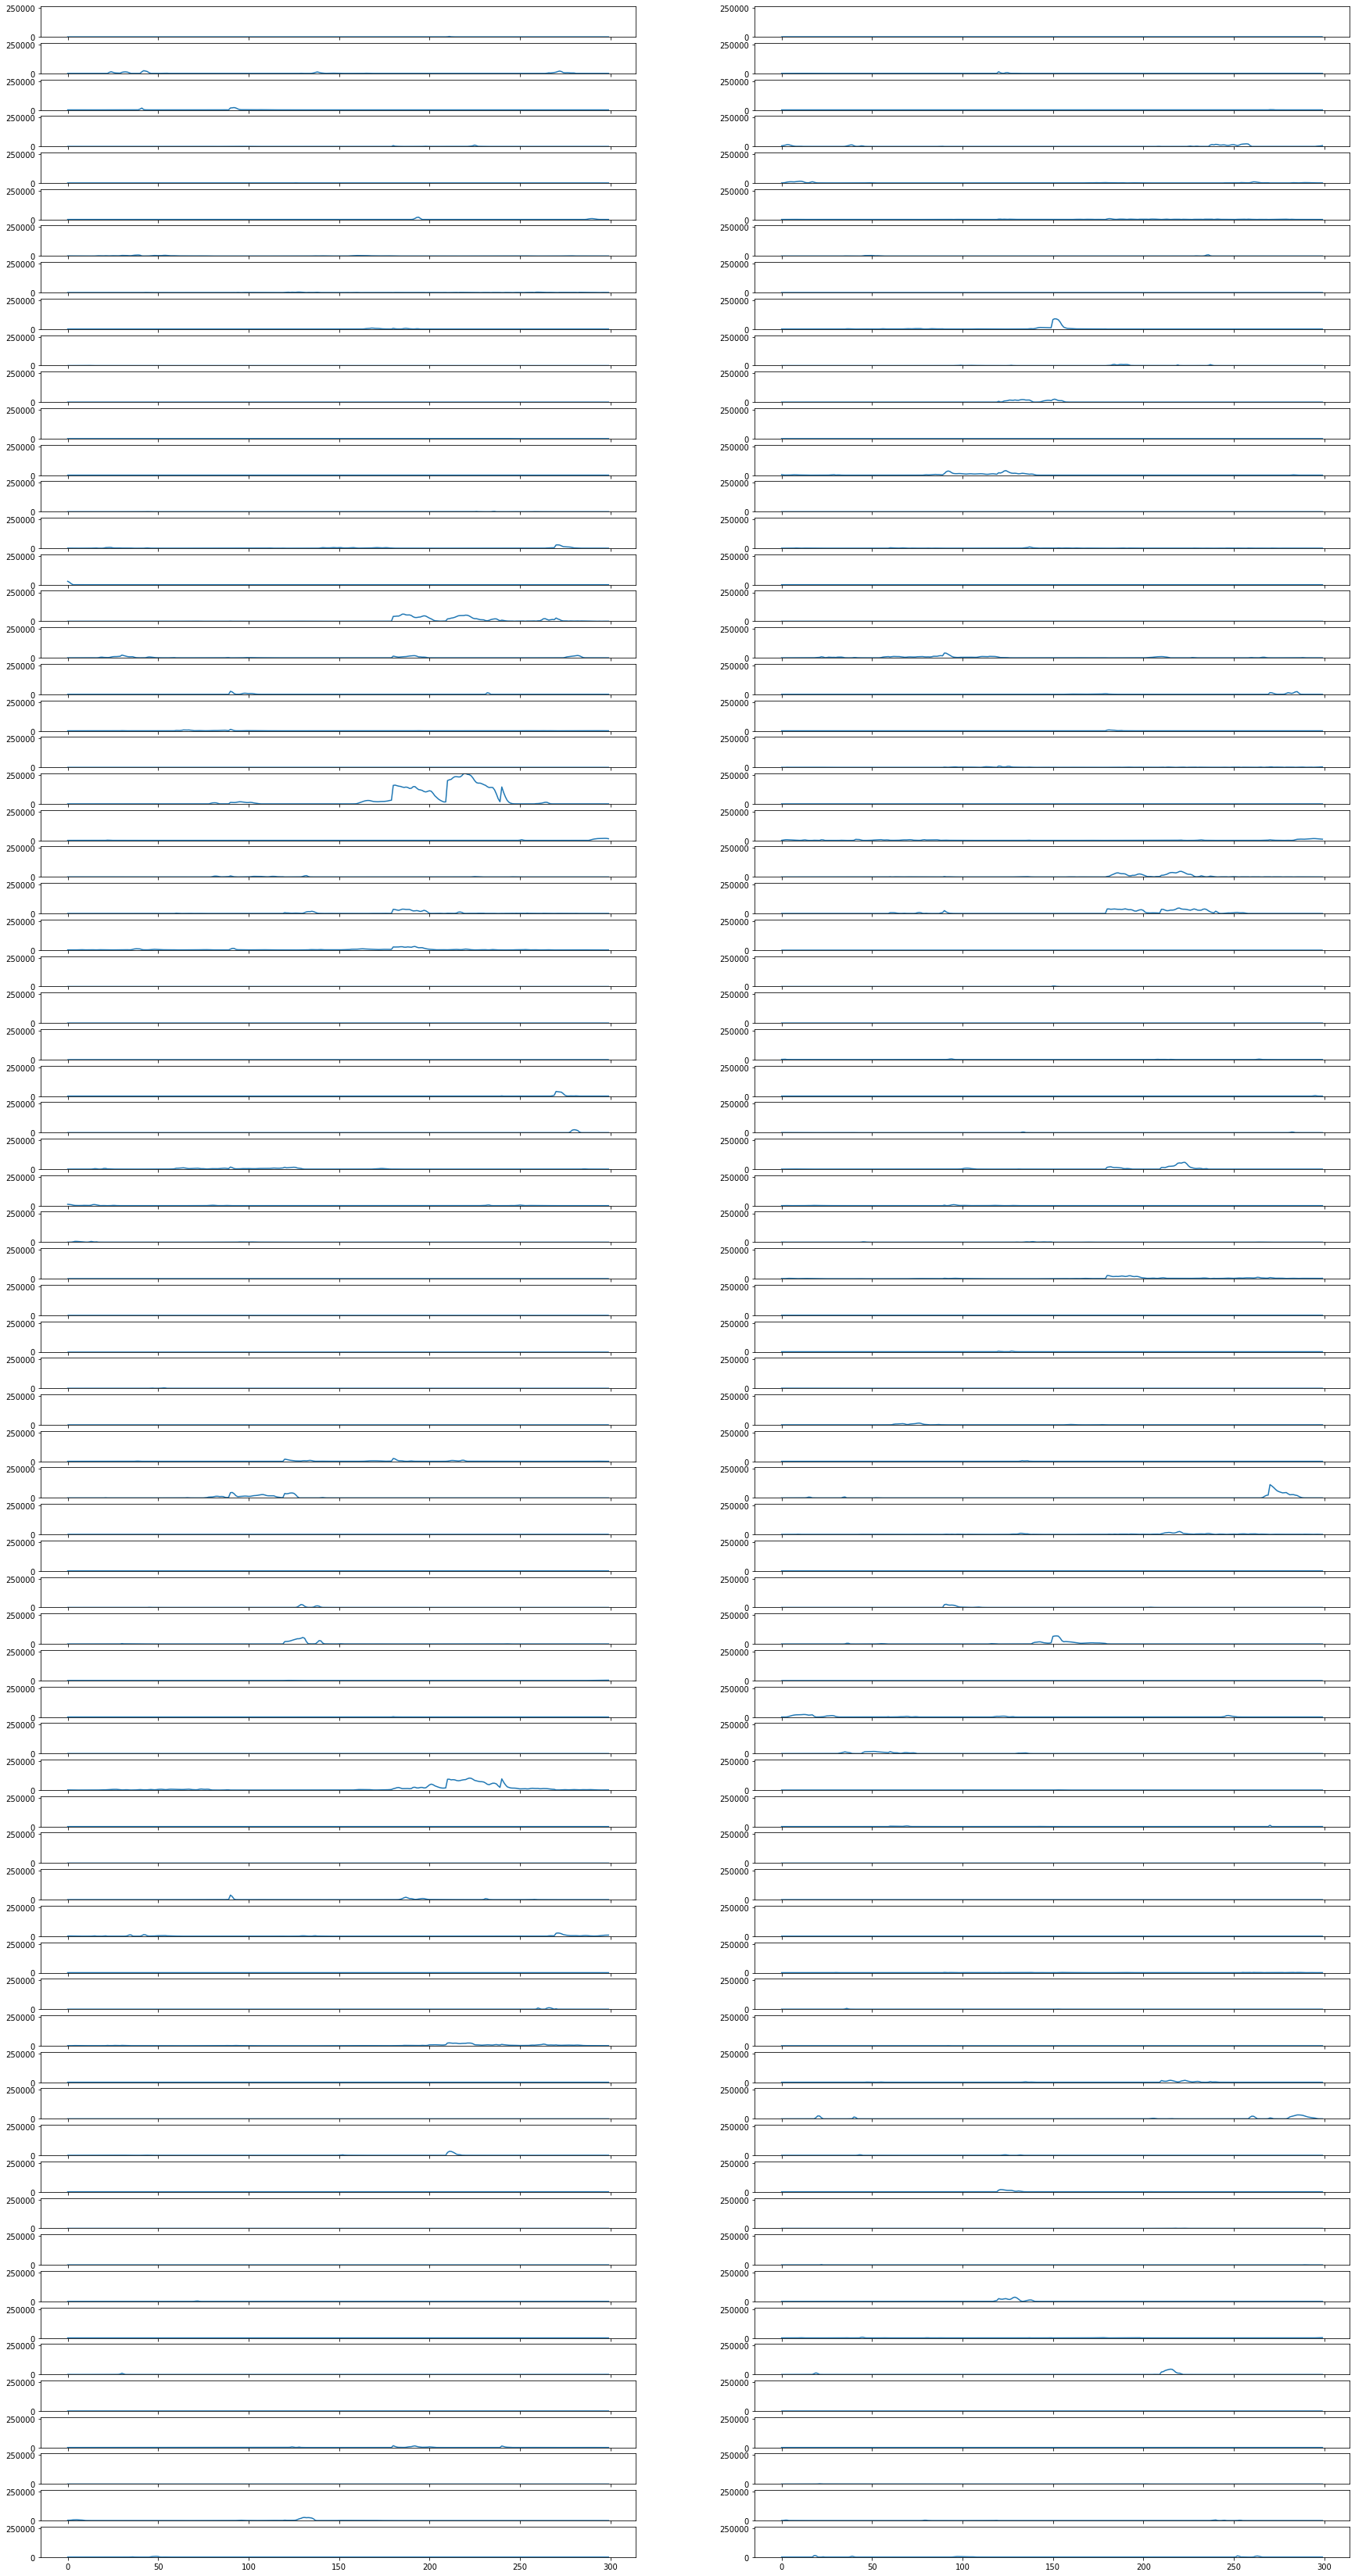

In [93]:
sum_fig, sum_axs = plt.subplots(70, 2, figsize=(30, 60))

plt.setp(
    sum_axs,
    ylim=(
        trace_act_usage.sum((-2, -1)).min(0).values.min(0).values - 0.05,
        trace_act_usage.sum((-2, -1)).max(0).values.max(0).values + 0.05,
    ),
)

for feat_ind in range(trace_act_usage.shape[1]):
    # sum_act_usage = trace_act_usage[:, feat_ind].sum(-2, -1)
    if feat_ind < trace_act_usage.shape[1] // 2:
        sum_axs[feat_ind, 0].plot(
            range(len(trace_act_usage[:, feat_ind].sum((-2, -1)))), trace_act_usage[:, feat_ind].sum((-2, -1))
        )
    else:
        sum_axs[feat_ind - (trace_act_usage.shape[1] // 2), 1].plot(
            range(len(trace_act_usage[:, feat_ind].sum((-2, -1)))), trace_act_usage[:, feat_ind].sum((-2, -1))
        )
plt.show()

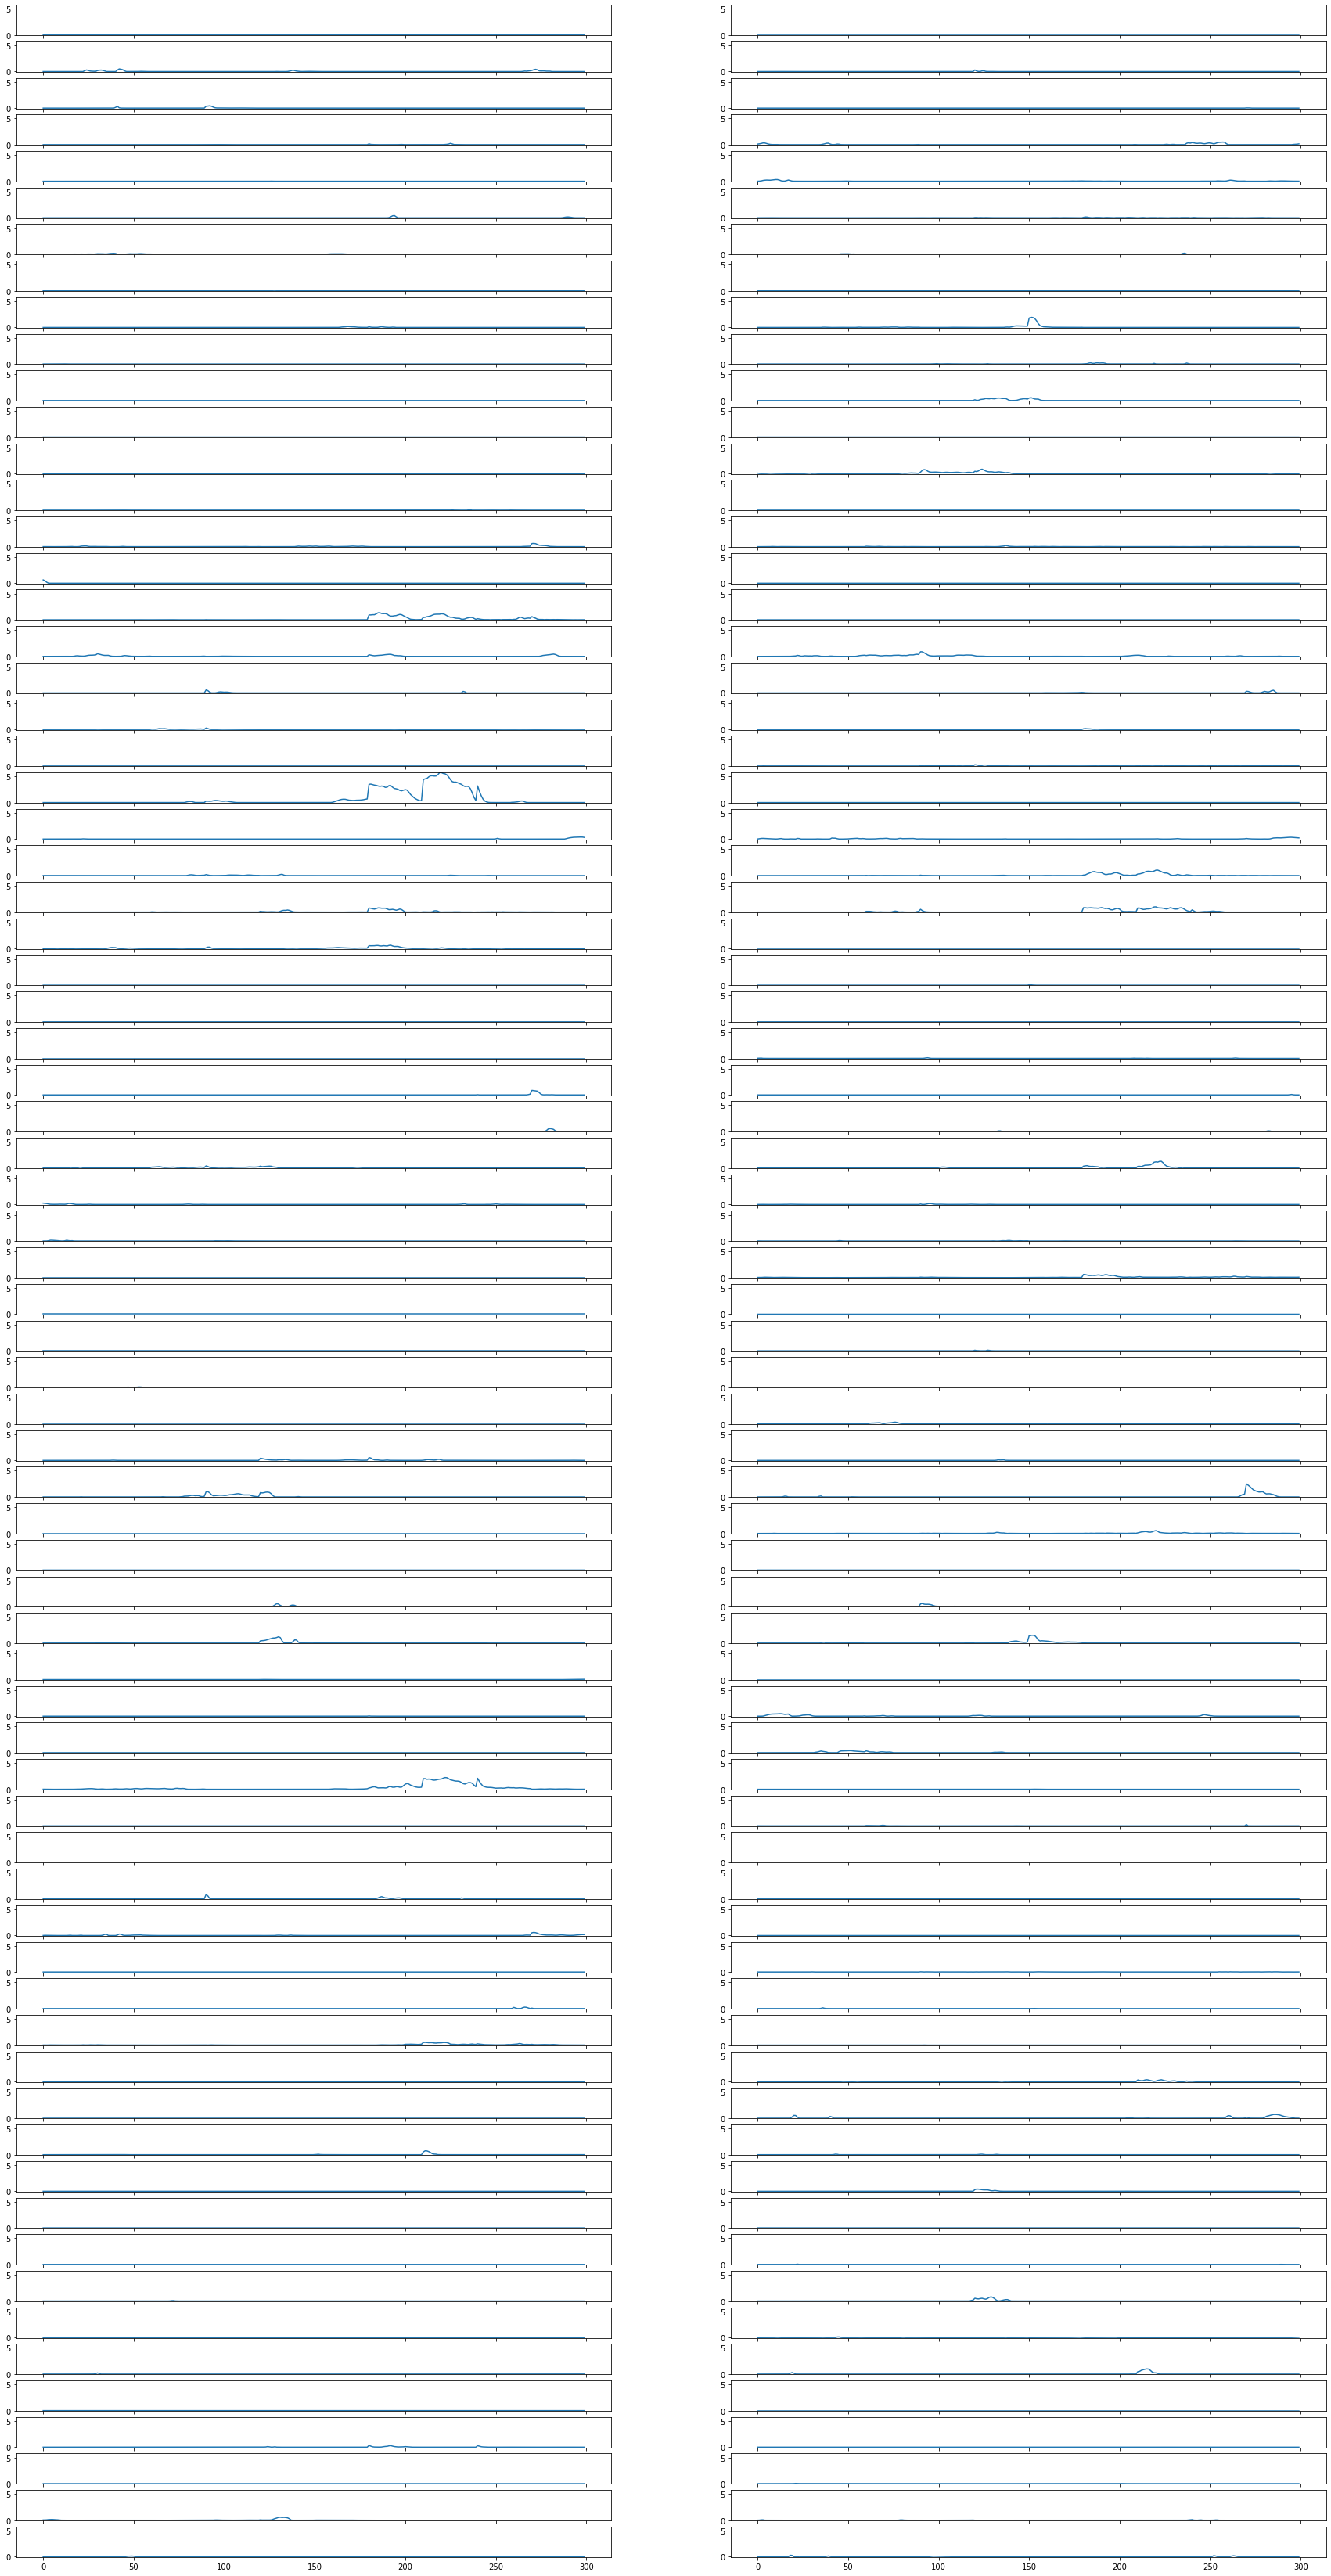

In [94]:
mean_fig, mean_axs = plt.subplots(70, 2, figsize=(30, 60))

plt.setp(
    mean_axs,
    ylim=(
        trace_act_usage.mean((-2, -1)).min(0).values.min(0).values - 0.05,
        trace_act_usage.mean((-2, -1)).max(0).values.max(0).values + 0.05,
    ),
)

for feat_ind in range(trace_act_usage.shape[1]):
    #  ave_act_usage = trace_act_usage[:, feat_ind].mean(-2, -1)
    if feat_ind < trace_act_usage.shape[1] // 2:
        mean_axs[feat_ind, 0].plot(
            range(len(trace_act_usage[:, feat_ind].mean((-2, -1)))), trace_act_usage[:, feat_ind].mean((-2, -1))
        )
    else:
        mean_axs[feat_ind - (trace_act_usage.shape[1] // 2), 1].plot(
            range(len(trace_act_usage[:, feat_ind].mean((-2, -1)))), trace_act_usage[:, feat_ind].mean((-2, -1))
        )

plt.show()

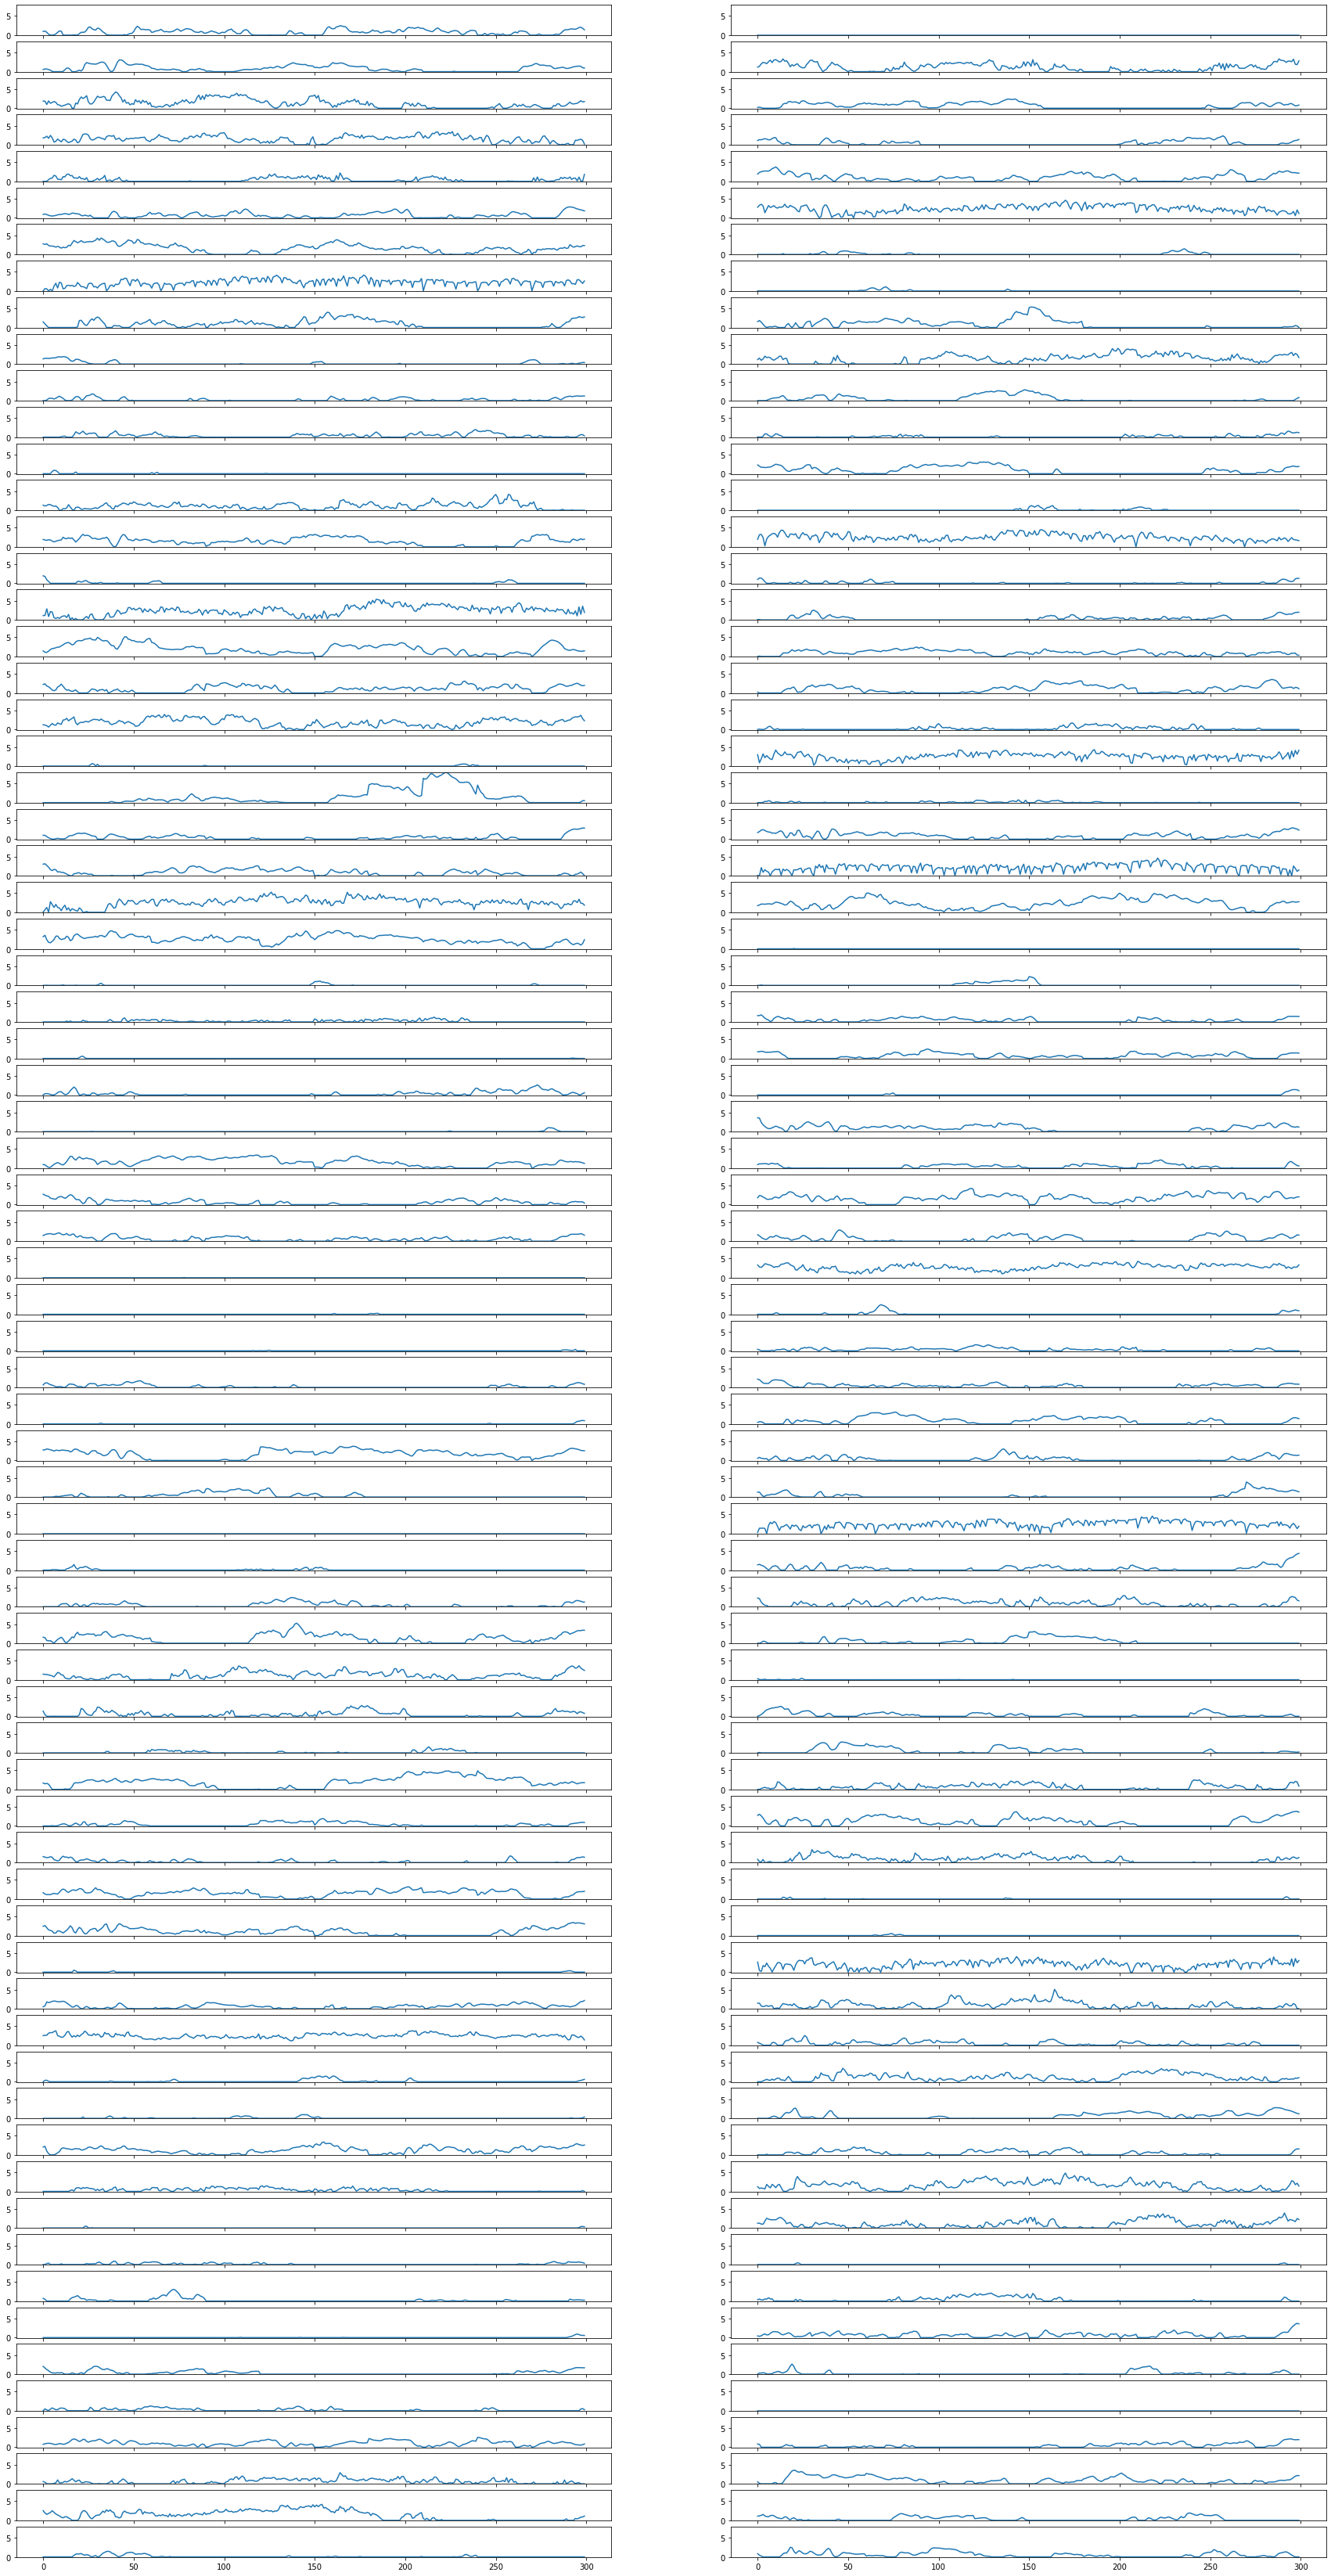

In [96]:
max_fig, max_axs = plt.subplots(70, 4, figsize=(30, 60))

reshaped_trace_act_usage = trace_act_usage.reshape(
    (len(trace_act_usage), trace_act_usage.shape[1], trace_act_usage.shape[-1] * trace_act_usage.shape[-2])
)

plt.setp(
    max_axs,
    ylim=(
        reshaped_trace_act_usage.max(-1).values.min(0).values.min(0).values - 0.05,
        reshaped_trace_act_usage.max(-1).values.max(0).values.max(0).values + 0.05,
    ),
)

for feat_ind in range(reshaped_trace_act_usage.shape[1]):
    if feat_ind < reshaped_trace_act_usage.shape[1] // 2:
        max_axs[feat_ind, 0].plot(
            range(len(reshaped_trace_act_usage[:, feat_ind].max(-1).values)),
            reshaped_trace_act_usage[:, feat_ind].max(-1).values,
        )

    else:
        max_axs[feat_ind - (reshaped_trace_act_usage.shape[1] // 2), 1].plot(
            range(len(reshaped_trace_act_usage[:, feat_ind].max(-1).values)),
            reshaped_trace_act_usage[:, feat_ind].max(-1).values,
        )

plt.show()

In [56]:
reshaped_trace_act_usage = trace_act_usage.reshape(
    (len(trace_act_usage), trace_act_usage.shape[1], trace_act_usage.shape[-1] * trace_act_usage.shape[-2])
)

print(
    feat_ind,
    "\n",
    reshaped_trace_act_usage.shape,
    "\n",
    reshaped_trace_act_usage[:, feat_ind].shape,
    "\n",
    reshaped_trace_act_usage[:, feat_ind].max(-1).values,
    len(reshaped_trace_act_usage[:, feat_ind].max(-1).values),
)

139 
 torch.Size([300, 140, 46208]) 
 torch.Size([300, 46208]) 
 tensor([8.3817e-01, 4.2675e-01, 2.2277e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.8757e-01, 8.1968e-01, 1.0216e+00, 1.0072e+00, 1.6444e+00,
        2.5167e+00, 2.4008e+00, 1.4826e+00, 9.2060e-01, 1.2849e+00, 1.6335e+00,
        1.3286e+00, 9.4761e-01, 7.9393e-01, 8.2763e-01, 1.1090e+00, 1.4913e+00,
        1.3226e+00, 1.0357e+00, 6.8210e-01, 5.0493e-01, 4.7154e-01, 5.2246e-01,
        7.8839e-01, 1.3310e+00, 1.8406e+00, 2.2167e+00, 1.9353e+00, 9.8422e-01,
        2.5471e-01, 2.5096e-02, 1.1644e-01, 3.2766e-01, 7.4171e-01, 1.1094e+00,
        1.1319e+00, 9.9612e-01, 9.9986e-01, 9.7138e-01, 8.5648e-01, 7.7861e-01,
        7.0228e-01, 6.9192e-01, 7.3167e-01, 7.7231e-01, 8.1214e-01, 7.8512e-01,
        2.2360e-01, 3.3686e-01, 3.6184e-01, 2.8218e-01, 3.0834e-01, 3.8156e-01,
        3.7558e-01, 3.3902e-01, 3.0799e-01, 3.3248e-01,

In [ ]:
# %time

# import tqdm

# def get_linked_dict_usage(model, lca_iters: int, dataset, batch_size: int, device, num_input=None):
#     if num_input is None:
#         num_input = dataset[0].shape[0]
#         num_input1 = dataset[1].shape[0]
#         print(num_input, dataset[0].shape)
#         print(num_input1, dataset[1].shape)
#     model.lr = 0
#     dict_usage = torch.zeros(model.module.trace_weights.shape[0], device=device)
#     for i in tqdm.tqdm(range(0, num_input, batch_size)):
#         print('starting...')
#         output = model(dataset, i)
#         print('finished...')

#     assert (not output.isnan().any()), "NaN encountered while running LCA"
#     dict_usage = (output > 0).sum(dim=(0, 2, 3, 4))
#     # batch, feature, x, y
#     print(output.shape)

#     return dict_usage

# linked_dict_usage = get_linked_dict_usage(lca, lca.module.lca_iters, (splitted10_wf[0].unsqueeze(1).cuda(), splitted10_wt[0][:, :100].cuda()), 10, 'cuda')

torch.Size([360, 100, 7])


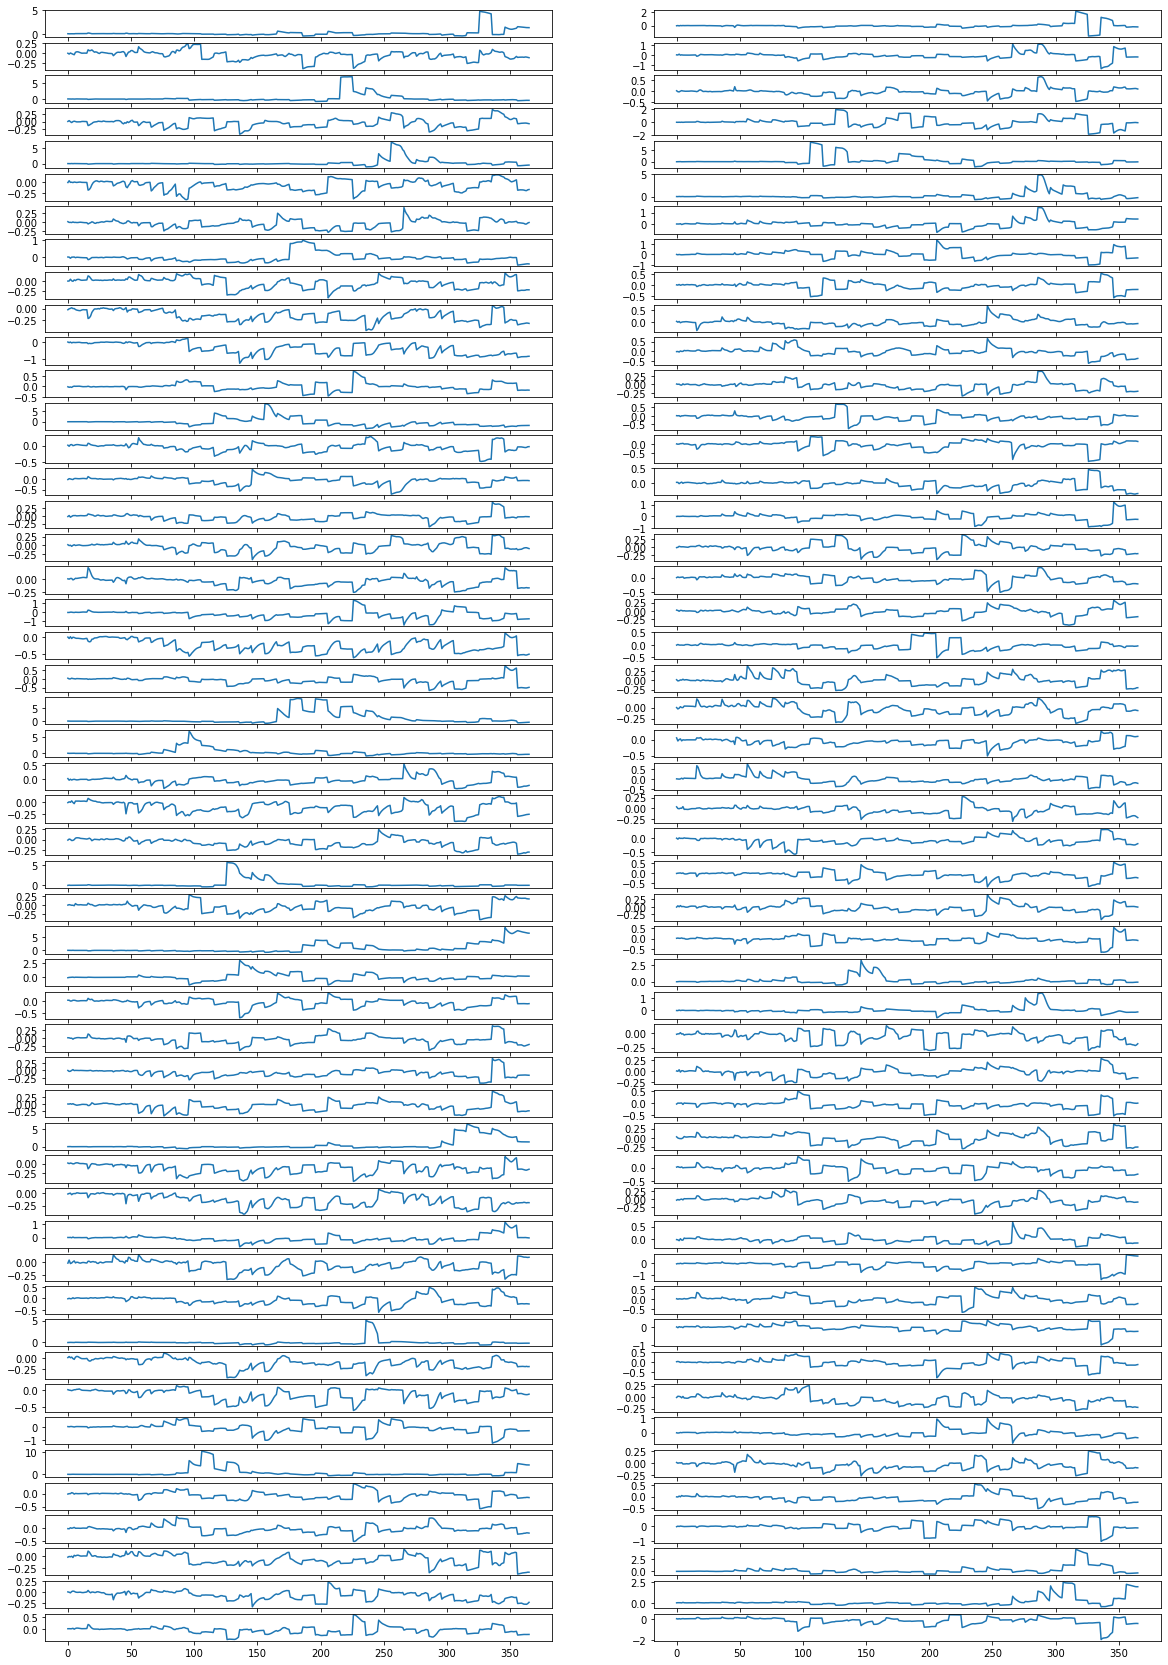

In [ ]:
%matplotlib inline

new_trace_recon_list = []
for trace_recon_sample in trace_recon_list:
    new_trace_recon_list.append(trace_recon_sample.detach())

t_trace_recons = torch.stack(new_trace_recon_list)
t_trace_recons = torch.reshape(
    t_trace_recons,
    (t_trace_recons.shape[0] * t_trace_recons.shape[1], t_trace_recons.shape[-2], t_trace_recons.shape[-1]),
)
print(t_trace_recons.shape)

fig, axs = plt.subplots(50, 2, figsize=(20, 30))
for i in range(t_trace_recons.shape[-2]):
    plot_trace_recon_list = []
    for j in range(t_trace_recons.shape[0]):
        if j == 0:
            for k in range(t_trace_recons.shape[-1]):
                plot_trace_recon_list.append(t_trace_recons[j, i, k].cpu().numpy())
        else:
            plot_trace_recon_list.append(t_trace_recons[j, i, -1].cpu().numpy())
    t_plot_trace_recons = np.array(plot_trace_recon_list)
    if i < t_trace_recons.shape[-2] // 2:
        axs[i, 0].plot(t_plot_trace_recons)
    else:
        axs[i - (t_trace_recons.shape[-2] // 2), 1].plot(t_plot_trace_recons)
plt.show()

In [ ]:
# %matplotlib inline

# # print(len(acts_list))
# # for act_ind, act_sample in enumerate (acts_list):
# # 	if act_ind == 0: print(act_sample.shape, act_sample)

# new_acts_list = []
# for acts_sample in acts_list:
#     acts_sample = acts_sample.cpu()
#     new_acts_list.append(acts_sample.cpu())

# t_acts = torch.stack(new_acts_list).to("cpu")
# t_acts = torch.reshape(
#     t_acts.squeeze(), (t_acts.shape[0] * t_acts.shape[1], t_acts.shape[2], t_acts.shape[-2], t_acts.shape[-1])
# )
# print(t_acts.shape)
# for i in range(t_acts.shape[1]):
#     if not os.path.exists(f"../reports/images_acts/cell{i+1}lca/"):
#         os.makedirs(f"../reports/images_acts/cell{i+1}lca/")
#     act_imgs = []

#     for j in range(t_acts.shape[0]):
#         save_image(t_acts[j, i, :, :], f"../reports/images_acts/cell{i+1}lca/img{j}.png")

#     for act_path in sorted(glob.glob(f"../reports/images_acts/cell{i+1}lca/*.png")):
#         # print(img_path, imageio.imread(img_path).shape)
#         act_imgs.append(imageio.imread(act_path))

#     imageio.mimsave(f"../reports/movies_acts/movie_lca_cell_{i+1}.gif", act_imgs)
# plt.show()

torch.Size([1800, 140, 80, 128])


/tmp/ipykernel_3437148/2428637601.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  act_imgs.append(imageio.imread(act_path))


# Visualizations

### Pre-trained LCA Vis

In [ ]:
# %matplotlib inline
# # ONLY if loading from pre-trained model
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# pretrain_lca = torch.load('../models/plotVidFixLinkDict.pth', map_location=device)

# windowed_frames_batch = torch.unsqueeze(splitted10_wf[100], 1).to(device)
# windowed_traces_batch = splitted10_wt[100][:, :100].to(device)

# code = pretrain_lca((windowed_frames_batch, windowed_traces_batch))
# recon, trace_recon = pretrain_lca.module.compute_recon(code, pretrain_lca.module.weights, True)

# pretrain_lca.module.update_weights(code, windowed_frames_batch - recon, windowed_traces_batch - trace_recon, len(splitted10_wt))
# fig1, axs1 = plt.subplots(1,7, figsize=(16,9))
# fig2, axs2 = plt.subplots(1,7, figsize=(16,9))
# fig3, axs3 = plt.subplots(1,7, figsize=(16,9))
# for a_ind, (a1, a2, a3) in enumerate(zip(axs1, axs2, axs3)):
#     trace_recon_error = windowed_traces_batch - trace_recon
#     trace_recon_samples = trace_recon[0].squeeze().squeeze().cpu().numpy()

#     recon_error = windowed_frames_batch - recon
#     recon_samples = recon[0].squeeze().squeeze().cpu().numpy()
#     recon_error_samples = recon_error[0].squeeze().squeeze().cpu().numpy()


#     recon_sample = recon_samples[a_ind]
#     recon_error_sample = recon_error_samples[a_ind]
#     inputs_sample = (recon_error_sample + recon_sample)

#     recon_sample = (recon_sample - recon_sample.min()) / (recon_sample.max() - recon_sample.min())
#     inputs_sample = (inputs_sample - inputs_sample.min()) / (inputs_sample.max() - inputs_sample.min())

#     img1 = a1.imshow(inputs_sample, cmap='gray')
#     img2 = a2.imshow(recon_sample, cmap='gray')
#     img3 = a3.imshow(recon_error_sample, cmap='gray')

#     a1.set_title(f'Input frame{a_ind+1}')
#     a2.set_title(f'Recon frame{a_ind+1}')
#     a3.set_title(f'Recon Error frame{a_ind+1}')
# plt.show()
# plt.close()

In [ ]:
# T = pretrain_lca.module.weights.shape[2]
# grids = []
# for t in range(T):
#     grids.append(make_grid(pretrain_lca.module.weights[:, :, t],
#                            int(math.sqrt(pretrain_lca.module.weights.shape[0])),
#                            normalize=False, scale_each=False, pad_value=0.5).cpu())
# final_grids = torch.stack(grids).permute(0, 2, 3, 1)
# imageio.mimwrite(f"../reports/plotVidFixLinkDict.gif", final_grids.cpu().numpy(), "gif")
# exp_weight_grid = make_feature_grid(pretrain_lca.module.trace_weights[:, 0].squeeze(-1).moveaxis(1, -1))
# weight_grid = make_feature_grid(pretrain_lca.module.trace_weights.squeeze(-1).squeeze(-1))
# # arrange by neuron activation frequency (maximum to minimum)
# for i in range(exp_weight_grid.shape[0] % PRINT_FREQ + 10):
#     plt.plot(exp_weight_grid[i].cpu().numpy())
#     # plt.plot(weight_grid[i].cpu().numpy())
#     plt.grid()
#     plt.show()
#     plt.close()

In [ ]:
# for i in range(len(trace_recon_error)):

#     plt.close()
#     fig, axs = plt.subplots(1, 2, figsize=(30, 20))

#     axs[0].plot((trace_recon_error[i, 0] + trace_recon[i, 0]).cpu().numpy(), linewidth=2, label = 'input')
#     axs[0].plot(trace_recon.cpu().numpy()[i, 0], c='r', linewidth=2, label = 'reconstruction')

#     axs[1].plot(trace_recon_error[i, 0].cpu().numpy(), c='g')

#     axs[0].set_title('Trace Input and Reconstruction')
#     axs[1].set_title('Trace Reconstruction Error')
#     axs[0].legend(loc='upper right')
#     plt.axis('tight')
#     axs[1].grid()
#     axs[0].grid()
#     plt.show()

### Video Reconstruction

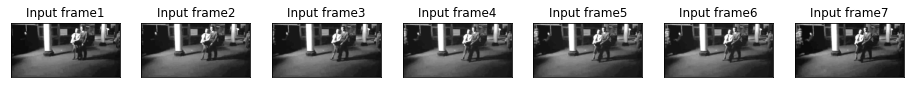

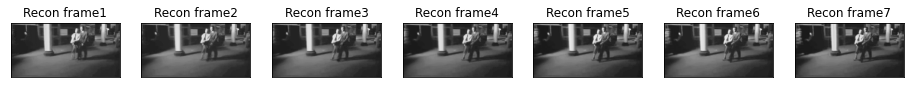

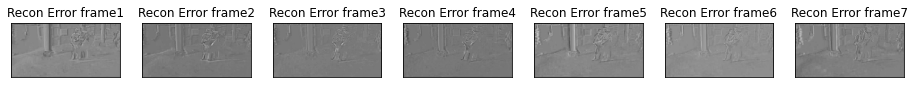

In [ ]:
fig1, axs1 = plt.subplots(1, 7, figsize=(16, 9))
fig2, axs2 = plt.subplots(1, 7, figsize=(16, 9))
fig3, axs3 = plt.subplots(1, 7, figsize=(16, 9))
for ind, (a1, a2, a3) in enumerate(zip(axs1, axs2, axs3)):
    recon_error = windowed_frames_batch - recon

    recon_samples = recon[0].squeeze().squeeze().cpu().numpy()

    recon_error_samples = recon_error[0].squeeze().squeeze().cpu().numpy()

    recon_sample = recon_samples[ind]
    recon_error_sample = recon_error_samples[ind]
    inputs_sample = recon_error_sample + recon_sample

    recon_sample = (recon_sample - recon_sample.min()) / (recon_sample.max() - recon_sample.min())
    inputs_sample = (inputs_sample - inputs_sample.min()) / (inputs_sample.max() - inputs_sample.min())

    img1 = a1.imshow(inputs_sample, cmap="gray")
    img2 = a2.imshow(recon_sample, cmap="gray")
    img3 = a3.imshow(recon_error_sample, cmap="gray")

    a1.set_title(f"Input frame{ind+1}")
    a2.set_title(f"Recon frame{ind+1}")
    a3.set_title(f"Recon Error frame{ind+1}")

    a1.get_xaxis().set_visible(False)
    a1.get_yaxis().set_visible(False)
    a2.get_xaxis().set_visible(False)
    a2.get_yaxis().set_visible(False)
    a3.get_xaxis().set_visible(False)
    a3.get_yaxis().set_visible(False)
plt.show()

### Activation Histogram

torch.Size([10, 140, 1, 152, 304]) 
 torch.Size([140, 100, 7, 1, 1]) 
 (140,) 
 [295 305 292 305 299 282 303 338 302 326 306 313 327 309 316 339 307 302
 338 315 321 279 314 292 324 306 305 279 296 301 206 315 313 310 309 320
 324 306 282 319 328 326 323 315 330 294 303 312 309 316 321 314 321 346
 315 316 325 319 318 290 319 316 292 331 304 237 318 296 329 288 292 305
 322 304 304 313 317 316 301 303 302 317 313 276 312 318 322 289 321 273
 308 334 291 300 256 264 288 321 331 298 311 311 330 304 321 296 317 308
 346 302 308 328 319 297 344 332 303 300 302 304 333 294 288 314 322 320
 321 291 303 328 314 330 296 321 322 301 297 310 323 315] 
 (140,) 
 462080
(140, 2) 1.0 0.0


/home/gonz495/miniconda3/envs/lca/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


<AxesSubplot:title={'center':'average sparsity: 0.4413061224489796'}, xlabel='feature'>

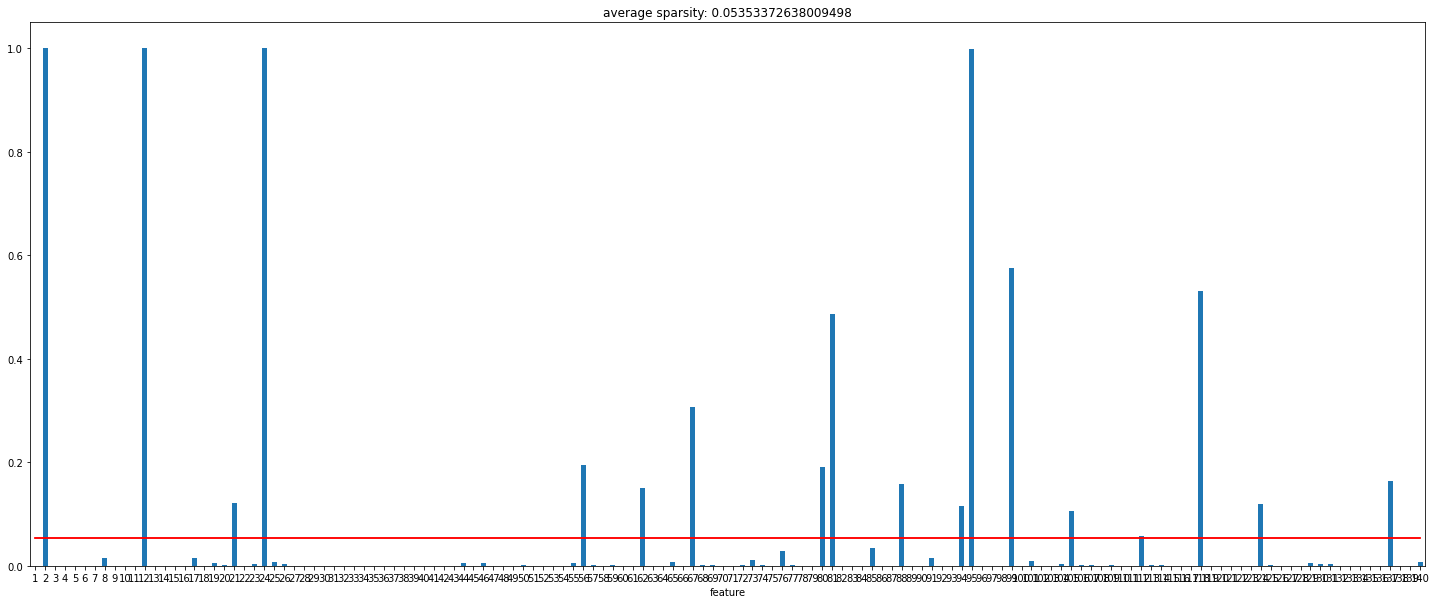

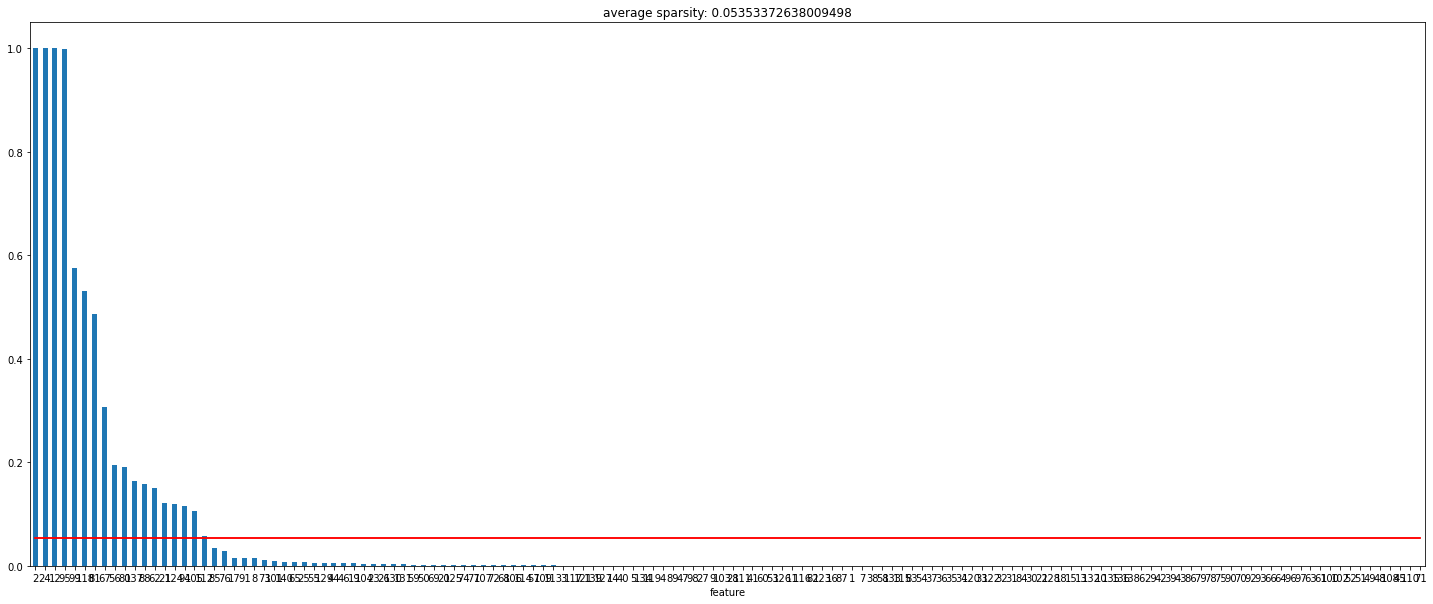

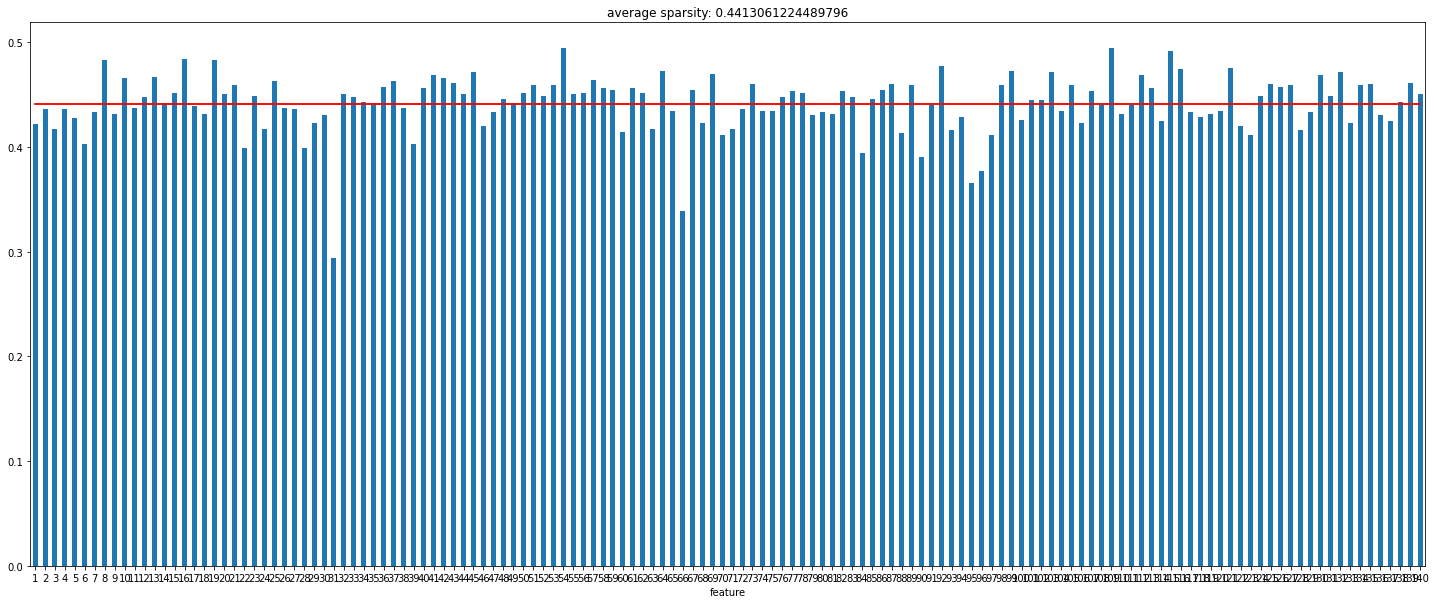

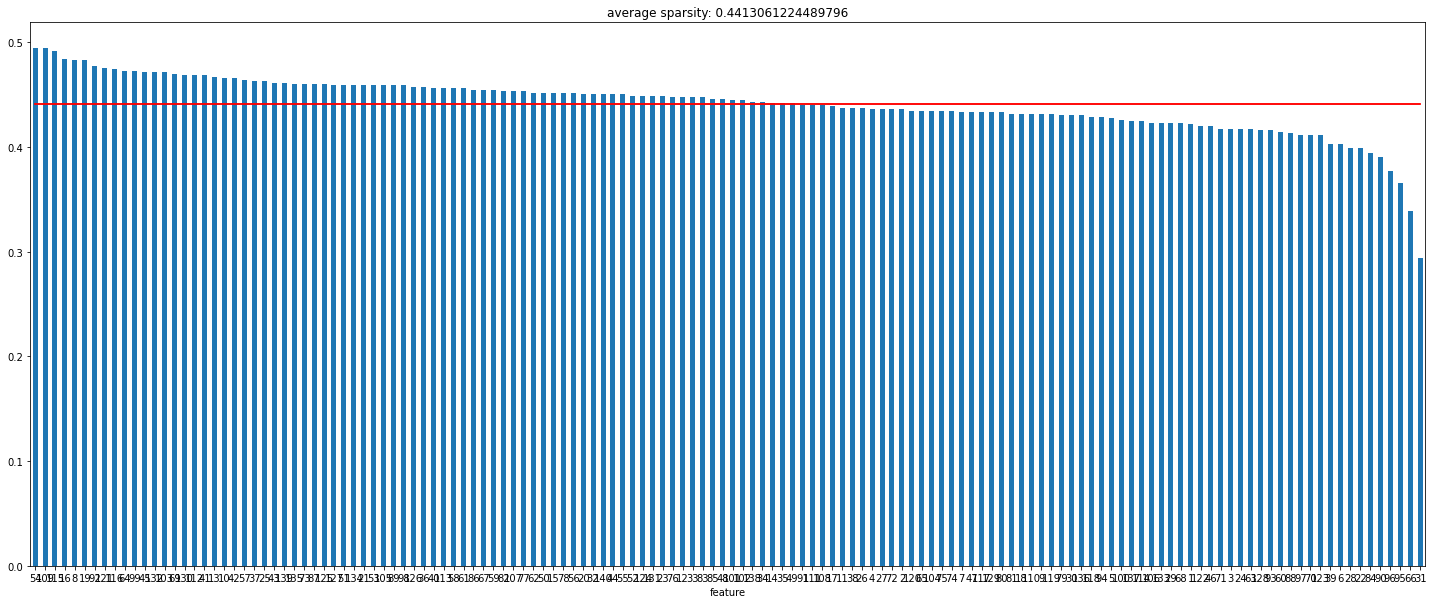

In [ ]:
features_overall_mean_batch_array = (lca.module.trace_weights > 0).cpu().numpy().sum(axis=(1, 2, 3)).squeeze()
v1_overall_mean_batch_array = (code > 0).cpu().numpy().sum(axis=(0, 3, 4)).squeeze()

print(
    code.shape,
    "\n",
    lca.module.trace_weights.shape,
    "\n",
    v1_overall_mean_batch_array.shape,
    "\n",
    features_overall_mean_batch_array,
    "\n",
    features_overall_mean_batch_array.shape,
    "\n",
    code.shape[0] * code.shape[-1] * code.shape[-2],
)

bool_feat_freq_df = pd.DataFrame(columns=["feature", "frequency"])
bool_act_freq_df = pd.DataFrame(columns=["feature", "frequency"])

for n in range(len(v1_overall_mean_batch_array)):
    bool_act_freq_df.loc[n, "feature"] = n + 1
    bool_feat_freq_df.loc[n, "feature"] = n + 1
    bool_feat_freq_df.loc[n, "frequency"] = v1_overall_mean_batch_array[n] / (
        code.shape[0] * code.shape[-1] * code.shape[-2]
    )
    bool_act_freq_df.loc[n, "frequency"] = features_overall_mean_batch_array[n] / (
        lca.module.trace_weights.shape[1] * lca.module.trace_weights.shape[2]
    )

print(bool_feat_freq_df.shape, bool_feat_freq_df["frequency"].max(), bool_feat_freq_df["frequency"].min())

mean_feat_sparsity = bool_feat_freq_df["frequency"].mean()
mean_feat_sparsity_df = bool_feat_freq_df * 0 + mean_feat_sparsity
ax1 = bool_feat_freq_df.plot.bar(x="feature", y="frequency", figsize=(25, 10), legend=False)
mean_feat_sparsity_df.plot(ax=ax1, color="r", title=f"average sparsity: {mean_feat_sparsity}", legend=False)

ax2 = bool_feat_freq_df.sort_values(by=["frequency"], ascending=False).plot.bar(
    x="feature", y="frequency", figsize=(25, 10), legend=False
)
mean_feat_sparsity_df.plot(ax=ax2, color="r", title=f"average sparsity: {mean_feat_sparsity}", legend=False)


mean_act_sparsity = bool_act_freq_df["frequency"].mean()
mean_act_sparsity_df = bool_act_freq_df * 0 + mean_act_sparsity
ax3 = bool_act_freq_df.plot.bar(x="feature", y="frequency", figsize=(25, 10), legend=False)
mean_act_sparsity_df.plot(ax=ax3, color="r", title=f"average sparsity: {mean_act_sparsity}", legend=False)

ax4 = bool_act_freq_df.sort_values(by=["frequency"], ascending=False).plot.bar(
    x="feature", y="frequency", figsize=(25, 10), legend=False
)
mean_act_sparsity_df.plot(ax=ax4, color="r", title=f"average sparsity: {mean_act_sparsity}", legend=False)

### Video Feature Dictionary

In [ ]:
T = lca.module.weights.shape[2]
grids = []
for t in range(T):
    grids.append(
        make_grid(
            lca.module.weights[:, :, t],
            int(math.sqrt(lca.module.weights.shape[0])),
            normalize=False,
            scale_each=False,
            pad_value=0.5,
        ).cpu()
    )
print(lca.module.weights.shape)
print(torch.stack(grids).shape)
final_grids = torch.stack(grids).permute(0, 2, 3, 1).cpu().numpy()
imageio.mimwrite(f"../reports/test_link_dict.gif", final_grids, "gif")

Lossy conversion from float32 to uint8. Range [-0.3825894594192505, 0.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.32198071479797363, 0.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.32895466685295105, 0.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.331642210483551, 0.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.32795748114585876, 0.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.3193412721157074, 0.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.4178277254104614, 0.5052105188369751]. Convert image to uint8 prior to saving to suppress this warning.


torch.Size([140, 1, 7, 9, 9])
torch.Size([7, 3, 145, 123])


In [ ]:
exp_weight_grid = make_feature_grid(lca.module.trace_weights[:, 0].squeeze(-1).moveaxis(1, -1))
weight_grid = make_feature_grid(lca.module.trace_weights.squeeze(-1).squeeze(-1))
# arrange by neuron activation frequency (maximum to minimum)
for i in range(exp_weight_grid.shape[0] % PRINT_FREQ + 10):
    plt.plot(exp_weight_grid[i].cpu().numpy())
    # plt.plot(weight_grid[i].cpu().numpy())
    plt.grid()
    plt.show()
    plt.close()

In [ ]:
%matplotlib inline
# IMP: LOOK AT RECON ERROR PERCENTAGE (recon error/[DIVIDED] by input?)
for i in range(len(trace_recon_error)):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot((trace_recon_error + trace_recon)[i, 0].cpu().numpy(), linewidth=2, label="input")
    axs[0].plot(trace_recon.cpu().numpy()[i, 0], c="r", linewidth=2, label="reconstruction")
    axs[1].plot(trace_recon_error[i, 0].cpu().numpy(), c="g")
    axs[0].set_title("Trace Input and Reconstruction")
    axs[1].set_title("Trace Reconstruction Error")
    plt.legend(loc="upper right")
    axs[0].set_ylim(trace_recon[i, 0].detach().cpu().min() - 1, trace_recon[i, 0].detach().cpu().max() + 1)
    axs[0].grid()
    axs[1].set_ylim(trace_recon_error[i, 0].detach().cpu().min() - 1, trace_recon_error[i, 0].detach().cpu().max() + 1)
    axs[1].grid()

    plt.show()
    plt.close()

In [ ]:
for i in range(len(trace_recon_error)):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].plot((trace_recon_error + trace_recon)[i, 0].cpu().numpy())
    axs[1].plot(trace_recon.cpu().numpy()[i, 0])
    axs[2].plot(trace_recon_error[i, 0].cpu().numpy())
    axs[0].set_title("Trace Input")
    axs[1].set_title("Trace Reconstruction")
    axs[2].set_title("Trace Reconstruction Error")

    for ax in axs:
        ax.set_ylim(-3, 3)
        ax.grid()

    plt.show()
    plt.close()

# LCA Testing 